In [148]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.special import roots_legendre 

Problema:

$$-\alpha u'' + \beta u' + \gamma u = f$$

$$u(0) = u_i$$
$$u(1) = u_f$$

Discretização de u:

$$u=\sum_k^n a_k \phi_k + u_i\phi_i + u_f \phi_f$$

em que $\phi_k(0)=\phi_k(1)=0$, $\phi_i(0)=1$ e $\phi_f(1)=1$.

A função teste v:

$$v=\sum_k^n b_k \phi_k$$

A forma fraca do problema é

$$\alpha\int u' v' dx + \beta \int u' v dx + \gamma \int u v dx = \int f v\, dx$$

em que o termo de contorno é nulo pois $v(0)=v(1)=0$.

O método de galerkin nos fornece o problema

$$\sum_t K_{tl}a_t = F_l$$

em que 

$$K_{tl} = \alpha \int \phi_t' \phi_l'dx + \beta \int \phi_t' \phi_l\,dx + \gamma \int \phi_t \phi_l\,dx$$

e

$$F_l = \int f \phi_l\,dx - \alpha \left[ \int \left( u_i\phi_i' + u_f\phi_f'\right) \phi_l'dx\right]- \beta \left[ \int \left( u_i\phi_i' + u_f\phi_f'\right) \phi_l\,dx\right]- \gamma \left[ \int \left( u_i\phi_i + u_f\phi_f\right) \phi_l\,dx\right]$$

Os termos a mais no vetor de carga só contribuem para os elementos extremos.

Quadratura Gaussiana.

A fim de incluir os casos em que os $\alpha$, $\beta$ e $\gamma$ não são coeficientes constantes, mas sim funções, logo entram na integram da formulação fraca, vou mostrar como mapear e fazer a integração gaussiana.

para mapear a variável x entre os pontos a e b, para uma variável $\xi$  enter os pontos -1 e 1. Basta notar que o mapeamento deve preservar a proporção entre os pontos, ou seja,

$$\frac{x-a}{b-a}=\frac{\xi-(-1)}{1-(-1)}.$$

Portanto,

$$x(\xi)=\frac{h_e}{2}(\xi+1)+a.$$

Note que $\frac{dx}{d\xi}=\frac{h_e}{2}$ e $\frac{d\xi}{dx}=\frac{2}{h_e}$.

A integral de uma função f(x) é, portanto, dada por

$$\int_a^b f(x)\,dx= \int_{-1}^{1}f(\xi)\,\frac{dx}{d\xi}d\xi \approx \frac{h_e}{2} \sum_i f(\xi_i)w_i.$$

Vamos usar a quadratura gaussiana para calcular os termos da matriz de rigidez e vetor de carga dos elementos. Note que para o caso em que temos a integral das derivada, o termo do jacobino inverte, pois

$$\int_a^b \phi_i'(x) \phi_j'(x)\,dx=\int_a^b \frac{d\phi_i(x)}{dx} \frac{d\phi_j(x)}{dx}\,dx= \frac{h_e}{2}\int_{-1}^1 \frac{d\phi_i(\xi)}{d\xi} \frac{d\phi_j(\xi)}{d\xi}\,\left(\frac{d\xi}{dx}\right)^2d\xi=\frac{2}{h_e}\int_{-1}^1 \frac{d\phi_i(\xi)}{d\xi} \frac{d\phi_j(\xi)}{d\xi}\,d\xi$$

Vamos calcular os termos das matrizes para um único elemento.

Caso Linear

In [1]:
import sympy as sym

In [2]:
x,h,a,b,c,alfa,beta,gamma,fa,fb,ui,uf,u = sym.symbols('x,h,a,b,c,α,β,γ,f(a),f(b),u_i,u_f,u')

In [3]:
f_1 = (b-x)/h
f_2 = (x-a)/h

In [4]:
df_1 = sym.diff(f_1,x)
df_2 = sym.diff(f_2,x)

In [5]:
c11=sym.integrate(f_1*f_1,(x,a,b)).subs(b,h+a).simplify()
c12=sym.integrate(f_1*f_2,(x,a,b)).subs(b,h+a).simplify()
c21=sym.integrate(f_2*f_1,(x,a,b)).subs(b,h+a).simplify()
c22=sym.integrate(f_2*f_2,(x,a,b)).subs(b,h+a).simplify()
C=sym.Matrix([[c11,c12],[c21,c22]]);C

Matrix([
[h/3, h/6],
[h/6, h/3]])

In [6]:
C*6/h

Matrix([
[2, 1],
[1, 2]])

In [7]:
a11=sym.integrate(df_1*df_1,(x,a,b)).subs(b,h+a).simplify()
a12=sym.integrate(df_1*df_2,(x,a,b)).subs(b,h+a).simplify()
a21=sym.integrate(df_2*df_1,(x,a,b)).subs(b,h+a).simplify()
a22=sym.integrate(df_2*df_2,(x,a,b)).subs(b,h+a).simplify()
A=sym.Matrix([[a11,a12],[a21,a22]]);A

Matrix([
[ 1/h, -1/h],
[-1/h,  1/h]])

In [8]:
A*h

Matrix([
[ 1, -1],
[-1,  1]])

In [9]:
b11=sym.integrate(df_1*f_1,(x,a,b)).subs(b,h+a).simplify()
b12=sym.integrate(df_1*f_2,(x,a,b)).subs(b,h+a).simplify()
b21=sym.integrate(df_2*f_1,(x,a,b)).subs(b,h+a).simplify()
b22=sym.integrate(df_2*f_2,(x,a,b)).subs(b,h+a).simplify()
B=sym.Matrix([[b11,b12],[b21,b22]]);B.T

Matrix([
[-1/2, 1/2],
[-1/2, 1/2]])

In [10]:
B*2

Matrix([
[-1, -1],
[ 1,  1]])

In [11]:
Kel=alfa*A+beta*B+gamma*C;Kel

Matrix([
[h*γ/3 - β/2 + α/h, h*γ/6 - β/2 - α/h],
[h*γ/6 + β/2 - α/h, h*γ/3 + β/2 + α/h]])

In [12]:
Fel = C*sym.Matrix([fa,fb]);Fel

Matrix([
[f(a)*h/3 + f(b)*h/6],
[f(a)*h/6 + f(b)*h/3]])

Para os elementos extremos, temos os seguintes termos a mais para o vetor de carga

In [13]:
-ui*Kel[0,1]

-u_i*(h*γ/6 - β/2 - α/h)

In [14]:
-uf*Kel[1,0]

-u_f*(h*γ/6 + β/2 - α/h)

Caso Quadrático

In [15]:
def q_A(A,B,C):
    return 1/((A - B) *(A - C)), (-B - C)/((A - B) *(A - C)), (B *C)/((A - B)* (A - C))
def q_B(A,B,C):
    return -(1/((A - B)* (B - C))), (A + C)/((A - B) *(B - C)), -((A* C)/((A - B) *(B - C)))
def q_C(A,B,C):
    return -(1/((A - C) *(-B + C))), -((-A - B)/((A - C)* (-B + C))), -((A* B)/((A - C) *(-B + C)))

In [16]:
c1,c2,c3=q_A(a,b,c)
qA = c1*x**2+c2*x+c3
c1,c2,c3=q_B(a,b,c)
qB = c1*x**2+c2*x+c3
c1,c2,c3=q_C(a,b,c)
qC = c1*x**2+c2*x+c3

In [17]:
dqA = sym.diff(qA,x)
dqB = sym.diff(qB,x)
dqC = sym.diff(qC,x)

In [18]:
cAA=sym.integrate(qA*qA,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
cAB=sym.integrate(qA*qB,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
cAC=sym.integrate(qA*qC,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
cBA=sym.integrate(qB*qA,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
cBB=sym.integrate(qB*qB,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
cBC=sym.integrate(qB*qC,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
cCA=sym.integrate(qC*qA,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
cCB=sym.integrate(qC*qB,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
cCC=sym.integrate(qC*qC,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
C=sym.Matrix([[cAA,cAB,cAC],[cBA,cBB,cBC],[cCA,cCB,cCC]]);C

Matrix([
[2*h/15,   h/15,  -h/30],
[  h/15, 8*h/15,   h/15],
[ -h/30,   h/15, 2*h/15]])

In [19]:
C*30/h

Matrix([
[ 4,  2, -1],
[ 2, 16,  2],
[-1,  2,  4]])

In [20]:
aAA=sym.integrate(dqA*dqA,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
aAB=sym.integrate(dqA*dqB,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
aAC=sym.integrate(dqA*dqC,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
aBA=sym.integrate(dqB*dqA,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
aBB=sym.integrate(dqB*dqB,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
aBC=sym.integrate(dqB*dqC,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
aCA=sym.integrate(dqC*dqA,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
aCB=sym.integrate(dqC*dqB,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
aCC=sym.integrate(dqC*dqC,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
A=sym.Matrix([[aAA,aAB,aAC],[aBA,aBB,aBC],[aCA,aCB,aCC]]);A

Matrix([
[ 7/(3*h), -8/(3*h),  1/(3*h)],
[-8/(3*h), 16/(3*h), -8/(3*h)],
[ 1/(3*h), -8/(3*h),  7/(3*h)]])

In [21]:
A*3*h

Matrix([
[ 7, -8,  1],
[-8, 16, -8],
[ 1, -8,  7]])

In [327]:
bAA=sym.integrate(dqA*qA,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
bAB=sym.integrate(dqA*qB,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
bAC=sym.integrate(dqA*qC,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
bBA=sym.integrate(dqB*qA,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
bBB=sym.integrate(dqB*qB,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
bBC=sym.integrate(dqB*qC,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
bCA=sym.integrate(dqC*qA,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
bCB=sym.integrate(dqC*qB,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
bCC=sym.integrate(dqC*qC,(x,a,c)).subs(b,(a+c)/2).subs(c,h+a).simplify()
B=sym.Matrix([[bAA,bAB,bAC],[bBA,bBB,bBC],[bCA,bCB,bCC]]).T;B

Matrix([
[-1/2,  2/3, -1/6],
[-2/3,    0,  2/3],
[ 1/6, -2/3,  1/2]])

In [328]:
Keq=alfa*A+beta*B+gamma*C

Para os elementos extremos, temos os seguintes termos a mais para o vetor de carga

no ponto 1

In [29]:
-ui*Keq[0,1]

-u_i*(h*γ/15 + 2*β/3 - 8*α/(3*h))

no ponto 2

In [30]:
-ui*Keq[0,2]

-u_i*(-h*γ/30 - β/6 + α/(3*h))

ponto -1

In [31]:
-uf*Keq[1,0]

-u_f*(h*γ/15 - 2*β/3 - 8*α/(3*h))

ponto -22

In [32]:
-uf*Keq[2,0]

-u_f*(-h*γ/30 + β/6 + α/(3*h))

In [297]:
def quadratic_base(a,b,c):
        ac1,ac2,ac3 = q_A(a,b,c)
        bc1,bc2,bc3 = q_B(a,b,c)
        cc1,cc2,cc3 = q_C(a,b,c)
        phi_a = np.vectorize(lambda x: ac1*x**2+ac2*x+ac3)
        phi_b = np.vectorize(lambda x: bc1*x**2+bc2*x+bc3)
        phi_c = np.vectorize(lambda x: cc1*x**2+cc2*x+cc3)
        
        return phi_a, phi_b, phi_c
    
def dquadratic_base(a,b,c):
        ac1,ac2,ac3 = q_A(a,b,c)
        bc1,bc2,bc3 = q_B(a,b,c)
        cc1,cc2,cc3 = q_C(a,b,c)
        dphi_a = np.vectorize(lambda x: 2*ac1*x+ac2)
        dphi_b = np.vectorize(lambda x: 2*bc1*x+bc2)
        dphi_c = np.vectorize(lambda x: 2*cc1*x+cc2)
        
        return dphi_a, dphi_b, dphi_c
    
def linear_base(a,b):
    h = b-a
    
    phi_a = np.vectorize(lambda x: (b-x)/h)
    phi_b = np.vectorize(lambda x: (x-a)/h)
    
    return phi_a,phi_b

def dlinear_base(a,b):
    h = b-a
    
    dphi_a = np.vectorize(lambda x: -1/h)
    dphi_b = np.vectorize(lambda x: 1/h)
    
    return dphi_a,dphi_b

In [298]:
phi_a, phi_b = linear_base(-1,1)
dphi_a, dphi_b = dlinear_base(-1,1)

In [266]:
C*6/h

Matrix([
[2, 1],
[1, 2]])

In [294]:
ncAA = gauss_legendre(np.vectorize(lambda ξ:phi_a(ξ)*phi_a(ξ)),2)
ncAB = gauss_legendre(np.vectorize(lambda ξ:phi_a(ξ)*phi_b(ξ)),2)
ncBA = gauss_legendre(np.vectorize(lambda ξ:phi_b(ξ)*phi_a(ξ)),2)
ncBB = gauss_legendre(np.vectorize(lambda ξ:phi_b(ξ)*phi_b(ξ)),2)
sym.Matrix([[ncAA,ncAB],[ncBA,ncBB]])*h/2*(6/h)

Matrix([
[2.0, 1.0],
[1.0, 2.0]])

In [278]:
A

Matrix([
[ 1/h, -1/h],
[-1/h,  1/h]])

In [296]:
naAA = gauss_legendre(np.vectorize(lambda ξ:dphi_a(ξ)*dphi_a(ξ)),2)
naAB = gauss_legendre(np.vectorize(lambda ξ:dphi_a(ξ)*dphi_b(ξ)),2)
naBA = gauss_legendre(np.vectorize(lambda ξ:dphi_b(ξ)*dphi_a(ξ)),2)
naBB = gauss_legendre(np.vectorize(lambda ξ:dphi_b(ξ)*dphi_b(ξ)),2)
sym.Matrix([[naAA,naAB],[naBA,naBB]])*2/h*h

Matrix([
[ 1.0, -1.0],
[-1.0,  1.0]])

In [274]:
B

Matrix([
[-1/2, -1/2],
[ 1/2,  1/2]])

In [277]:
nbAA = gauss_legendre(np.vectorize(lambda x:dphi_a(x)*phi_a(x)),2)
nbAB = gauss_legendre(np.vectorize(lambda x:dphi_a(x)*phi_b(x)),2)
nbBA = gauss_legendre(np.vectorize(lambda x:dphi_b(x)*phi_a(x)),2)
nbBB = gauss_legendre(np.vectorize(lambda x:dphi_b(x)*phi_b(x)),2)
sym.Matrix([[nbAA,nbAB],[nbBA,nbBB]])

Matrix([
[-0.5, -0.5],
[ 0.5,  0.5]])

In [300]:
phi_a, phi_b, phi_c = quadratic_base(-1,0,1)
dphi_a, dphi_b, dphi_c = dquadratic_base(-1,0,1)


In [330]:
C*30/h

Matrix([
[ 4,  2, -1],
[ 2, 16,  2],
[-1,  2,  4]])

In [332]:
ncAA = gauss_legendre(np.vectorize(lambda ξ:phi_a(ξ)*phi_a(ξ)),4)
ncAB = gauss_legendre(np.vectorize(lambda ξ:phi_a(ξ)*phi_b(ξ)),4)
ncAC = gauss_legendre(np.vectorize(lambda ξ:phi_a(ξ)*phi_c(ξ)),4)

ncBA = gauss_legendre(np.vectorize(lambda ξ:phi_b(ξ)*phi_a(ξ)),4)
ncBB = gauss_legendre(np.vectorize(lambda ξ:phi_b(ξ)*phi_b(ξ)),4)
ncBC = gauss_legendre(np.vectorize(lambda ξ:phi_b(ξ)*phi_c(ξ)),4)

ncCA = gauss_legendre(np.vectorize(lambda ξ:phi_c(ξ)*phi_a(ξ)),4)
ncCB = gauss_legendre(np.vectorize(lambda ξ:phi_c(ξ)*phi_b(ξ)),4)
ncCC = gauss_legendre(np.vectorize(lambda ξ:phi_c(ξ)*phi_c(ξ)),4)

sym.Matrix([[ncAA,ncAB,ncAC],[ncBA,ncBB,ncBC],[ncCA,ncCB,ncCC]])*h/2*(30/h)

Matrix([
[ 4.0,  2.0, -1.0],
[ 2.0, 16.0,  2.0],
[-1.0,  2.0,  4.0]])

In [334]:
A*3*h

Matrix([
[ 7, -8,  1],
[-8, 16, -8],
[ 1, -8,  7]])

In [336]:


naAA = gauss_legendre(np.vectorize(lambda ξ:dphi_a(ξ)*dphi_a(ξ)),4)
naAB = gauss_legendre(np.vectorize(lambda ξ:dphi_a(ξ)*dphi_b(ξ)),4)
naAC = gauss_legendre(np.vectorize(lambda ξ:dphi_a(ξ)*dphi_c(ξ)),4)

naBA = gauss_legendre(np.vectorize(lambda ξ:dphi_b(ξ)*dphi_a(ξ)),4)
naBB = gauss_legendre(np.vectorize(lambda ξ:dphi_b(ξ)*dphi_b(ξ)),4)
naBC = gauss_legendre(np.vectorize(lambda ξ:dphi_b(ξ)*dphi_c(ξ)),4)

naCA = gauss_legendre(np.vectorize(lambda ξ:dphi_c(ξ)*dphi_a(ξ)),4)
naCB = gauss_legendre(np.vectorize(lambda ξ:dphi_c(ξ)*dphi_b(ξ)),4)
naCC = gauss_legendre(np.vectorize(lambda ξ:dphi_c(ξ)*dphi_c(ξ)),4)

sym.Matrix([[naAA,naAB,naAC],[naBA,naBB,naBC],[naCA,naCB,naCC]])*(2/h)*(3*h)

Matrix([
[ 7.0, -8.0,  1.0],
[-8.0, 16.0, -8.0],
[ 1.0, -8.0,  7.0]])

In [339]:
B*6

Matrix([
[-3,  4, -1],
[-4,  0,  4],
[ 1, -4,  3]])

In [341]:


nbAA = gauss_legendre(np.vectorize(lambda ξ:dphi_a(ξ)*phi_a(ξ)),4)
nbAB = gauss_legendre(np.vectorize(lambda ξ:dphi_a(ξ)*phi_b(ξ)),4)
nbAC = gauss_legendre(np.vectorize(lambda ξ:dphi_a(ξ)*phi_c(ξ)),4)

nbBA = gauss_legendre(np.vectorize(lambda ξ:dphi_b(ξ)*phi_a(ξ)),4)
nbBB = gauss_legendre(np.vectorize(lambda ξ:dphi_b(ξ)*phi_b(ξ)),4)
nbBC = gauss_legendre(np.vectorize(lambda ξ:dphi_b(ξ)*phi_c(ξ)),4)

nbCA = gauss_legendre(np.vectorize(lambda ξ:dphi_c(ξ)*phi_a(ξ)),4)
nbCB = gauss_legendre(np.vectorize(lambda ξ:dphi_c(ξ)*phi_b(ξ)),4)
nbCC = gauss_legendre(np.vectorize(lambda ξ:dphi_c(ξ)*phi_c(ξ)),4)

sym.Matrix([[nbAA,nbAB,nbAC],[nbBA,nbBB,nbBC],[nbCA,nbCB,nbCC]]).T*6

Matrix([
[-3.0,  4.0, -1.0],
[-4.0,    0,  4.0],
[ 1.0, -4.0,  3.0]])

In [33]:
#sanity check
def plot_elemento(X,k,q=False):
    fig, ax = plt.subplots()
    
    if(q):
        a = X[k-1]
        b = X[k]
        c = a/2+b/2
        h = b-a

        x = np.linspace(a,b,100)

        ac1,ac2,ac3 = q_A(a,b,c)
        bc1,bc2,bc3 = q_B(a,b,c)
        cc1,cc2,cc3 = q_C(a,b,c)
        phi_a = lambda x: ac1*x**2+ac2*x+ac3
        phi_b = lambda x: bc1*x**2+bc2*x+bc3
        phi_c = lambda x: cc1*x**2+cc2*x+cc3

        ax.plot(x,phi_a(x))
        ax.plot(x,phi_b(x))
        ax.plot(x,phi_c(x))
    else:
        a = X[k-1]
        b = X[k]
        h = b-a

        x = np.linspace(a,b,100)

        phi_a = lambda x: (b-x)/h
        phi_b = lambda x: (x-a)/h

        ax.plot(x,phi_a(x))
        ax.plot(x,phi_b(x))

    
    return fig,ax

In [ ]:
def gauss_legendre(f,n):
        x,w = roots_legendre(n)
        return np.dot(f(x),w)

In [35]:
X1 = np.linspace(0,1,100)
X2 = np.linspace(0,1,100)
X3 = np.linspace(0,1,100)
#soluções analítica para testes
s1 = lambda x: x-np.sinh(x)/np.sinh(1) # alfa=1, beta=0, gamma=1, f=x, u(0) = 0, u(1)=0
s1 = s1(X1)
s2 = lambda x: -x*(x-1)/2 # alfa=1, beta=0, gamma=0, f=1, u(0) = 0, u(1)=0
s2 = s2(X2)
s3 = lambda x: 1+0.7*x-x**2/2 # alfa=1, beta=0, gamma=0, f=1, u(0) = 1, u(1)=1.2
s3 = s3(X3)

In [36]:
# alfa=1, beta=-2, gamma=-3, f=x**3*np.exp(5*x)*np.cos(3*x), u(0) = 0, u(1)=1

import pandas

df = pandas.read_csv('s4.csv',header=None)

X4 = df[0].to_numpy()
s4 = df[1].to_numpy()

# alfa=1, beta=2, gamma=1, f=0, u(0) = 0, u(1)=1


df = pandas.read_csv('s5.csv',header=None)

X5 = df[0].to_numpy()
s5 = df[1].to_numpy()

# alfa=1, beta=0, gamma=1, f=np.cos(15*x), u(0) = 1, u(1)=1


df = pandas.read_csv('s6.csv',header=None)

X6 = df[0].to_numpy()
s6 = df[1].to_numpy()

# alfa=1, beta=100, gamma=1, f=np.cos(15*x), u(0) = 0, u(1)=0


df = pandas.read_csv('s7.csv',header=None)

X7 = df[0].to_numpy()
s7 = df[1].to_numpy()

# alfa=1, beta=0, gamma=1, f=np.cos(15*x), u(0) = 0, u(1)=0


df = pandas.read_csv('s8.csv',header=None)

X8 = df[0].to_numpy()
s8 = df[1].to_numpy()

# alfa=1, beta=1, gamma=0, f=np.cos(7*x), u(0) = 0, u(1)=0


df = pandas.read_csv('s9.csv',header=None)

X9 = df[0].to_numpy()
s9 = df[1].to_numpy()

In [37]:
def build_solution(X,u,LM,E):
    Xs = np.array([])
    S = np.array([])
    for i in E:
        pontos = LM[i-1]-1

        if(pontos[-1]==-2): # o elemento é linear
            S = np.append(S,[u[pontos[0]],u[pontos[1]]])
            Xs = np.append(Xs,[X[pontos[0]],X[pontos[1]]])
        else: # o elemento é quadrático
            ac1,ac2,ac3 = q_A(X[pontos[0]],X[pontos[1]],X[pontos[2]])
            bc1,bc2,bc3 = q_B(X[pontos[0]],X[pontos[1]],X[pontos[2]])
            cc1,cc2,cc3 = q_C(X[pontos[0]],X[pontos[1]],X[pontos[2]])
            phi_a = lambda x: ac1*x**2+ac2*x+ac3
            phi_b = lambda x: bc1*x**2+bc2*x+bc3
            phi_c = lambda x: cc1*x**2+cc2*x+cc3                              
            Xe = np.linspace(X[pontos[0]],X[pontos[2]],100)
            S = np.append(S,u[pontos[0]]*phi_a(Xe)+u[pontos[1]]*phi_b(Xe)+u[pontos[2]]*phi_c(Xe))
            Xs = np.append(Xs,Xe)

    return Xs,S

In [537]:
def fem_direto(X,alfa,beta,gamma,f,ui,uf,Q=[]):
    '''
    Resolve por elementos finitos a equação: -alfa u'' + beta u' + gamma u = f
    
    Parâmetros:
    X: a discretização do espaço. Não precisa ser homogêneo
    q: lista dos elementos que devem ser quadráticos
    alfa: valor que multiplica u''
    beta: valor que multiplica u'
    gamma: valor que multiplica u
    f: função de carga.
    ui: Condição de dirichlet em X[0]. 
    uf: Condição de dirichlet em X[-1].
    
    Retorno:
    K: Matriz de rigidez
    F: Vetor de Carga
    u: Solução do problema
    '''
    
    
    def A_e(h,q):
        '''q: True se o elemento é quadrático'''

        if(q):
             return np.array([[7,-8,1],[-8,16,-8],[1,-8,7]])/(3*h)
        return np.array([[1,-1],[-1,1]])/h

    def B_e(q):
        '''q: True se o elemento é quadrático'''

        if q:
            return np.array([[-3, 4, -1],[-4, 0, 4],[1, -4, 3]])/6
        return np.array([[-1,1],[-1,1]])/2

    def C_e(h,q):
        '''q: True se o elemento é quadrático'''

        if q:
            return np.array([[4, 2, -1],[2, 16, 2],[-1, 2, 4]])*h/30

        return np.array([[2,1],[1,2]])*h/6
    
    
    Q = np.array(Q)
    n = len(X) # number of points
    E = np.array(range(1,n)) # array of elements
    
    #Construo a matrix de checagem de elementos quadráticos. Uso essa matriz para saber se um dado elemento é quadrático.
    CheckQuadraticMatrix = E==-1
    aux = 0; # sempre que construimos a coluna para um elemento quadrático, incrementamos aux. Esse número representa
    # o número de nódulos intermediários adicionados no LM. 
    for value in Q:
        X = np.insert(X,value+aux,X[value+aux]/2+X[value+aux-1]/2)
        aux += 1
        CheckQuadraticMatrix = np.logical_or(CheckQuadraticMatrix,E==value)
        
    # construo a matriz local
    LM = np.array([])
    aux = 0; # sempre que construimos a coluna para um elemento quadrático, incrementamos aux. Esse número representa
    # o número de nódulos intermediários adicionados no LM. É usado nos elementos seguintes para que sejam
    # conectados os pontos certos.
    for i in E:
        if(CheckQuadraticMatrix[i-1]):
            LM = np.append(LM,np.array([aux+i,aux+i+1,aux+i+2]))
            aux += 1
        else:
            LM = np.append(LM,np.array([aux+i,aux+i+1,-1]))

    LM = LM.reshape(len(E),3).astype(int)
        
    # construo a matriz de rigidez e vetor de carga
    n = len(X) # repito novament pois X pode ter aumentado
    K = np.zeros(n*n).reshape(n,n)
    F = np.zeros(n)

    for i in E: #sem os elementos das pontas pois esses são colocados a mão
        pontos = LM[i-1]-1

        q = CheckQuadraticMatrix[i-1] # True se o elemento i é quadrático

        if(q):
            h = X[pontos[2]]-X[pontos[0]]
        else:
            h = X[pontos[1]]-X[pontos[0]]


        Ae = A_e(h,q)
        Be = B_e(q)
        Ce = C_e(h,q)

        if(q):
            Fe = Ce@f(np.array([X[pontos[0]],X[pontos[1]],X[pontos[2]]]))
        else:
            Fe = Ce@f(np.array([X[pontos[0]],X[pontos[1]]]))



        K[pontos[0],pontos[0]] += alfa*Ae[0,0]
        K[pontos[0],pontos[1]] += alfa*Ae[0,1]
        K[pontos[1],pontos[0]] += alfa*Ae[1,0]
        K[pontos[1],pontos[1]] += alfa*Ae[1,1]

        K[pontos[0],pontos[0]] += beta*Be[0,0]
        K[pontos[0],pontos[1]] += beta*Be[0,1]
        K[pontos[1],pontos[0]] += beta*Be[1,0]
        K[pontos[1],pontos[1]] += beta*Be[1,1]

        K[pontos[0],pontos[0]] += gamma*Ce[0,0]
        K[pontos[0],pontos[1]] += gamma*Ce[0,1]
        K[pontos[1],pontos[0]] += gamma*Ce[1,0]
        K[pontos[1],pontos[1]] += gamma*Ce[1,1]

        F[pontos[0]] += Fe[0]
        F[pontos[1]] += Fe[1]

        if(q):  
            K[pontos[0],pontos[2]] += alfa*Ae[0,2]
            K[pontos[1],pontos[2]] += alfa*Ae[1,2]

            K[pontos[2],pontos[0]] += alfa*Ae[2,0]
            K[pontos[2],pontos[1]] += alfa*Ae[2,1]
            K[pontos[2],pontos[2]] += alfa*Ae[2,2]

            K[pontos[0],pontos[2]] += beta*Be[0,2]
            K[pontos[1],pontos[2]] += beta*Be[1,2]

            K[pontos[2],pontos[0]] += beta*Be[2,0]
            K[pontos[2],pontos[1]] += beta*Be[2,1]
            K[pontos[2],pontos[2]] += beta*Be[2,2]

            K[pontos[0],pontos[2]] += gamma*Ce[0,1]
            K[pontos[1],pontos[2]] += gamma*Ce[1,2]

            K[pontos[2],pontos[0]] += gamma*Ce[2,0]
            K[pontos[2],pontos[1]] += gamma*Ce[2,1]
            K[pontos[2],pontos[2]] += gamma*Ce[2,2]

            F[pontos[2]] += Fe[2]

    # garante que os extremos respeitem as condições de contorno
    K[0,0] = 1
    F[0] = ui
    K[-1,-1] = 1
    F[-1] = uf
    
    F[1] += -ui*K[0,1]
    K[0,1] = K[1,0] = 0
    
    if(CheckQuadraticMatrix[0]):
        F[2] += -ui*K[0,2]
        K[2,0] = K[0,2]  = 0
    
    F[-2] += -uf*K[-2,-1]
    K[-2,-1]=K[-1,-2]=0
        
    if(CheckQuadraticMatrix[-1]):
        F[-3] += -uf*K[-3,-1]
        K[-1,-3]=K[-3,-1]=0

    u = solve(K,F)    

    return K,F,E,LM,X,u

In [531]:
def fem_gauss(X,alfa,beta,gamma,f,ui,uf,n=4,Q=[]):
    '''
    Resolve por elementos finitos a equação: -alfa u'' + beta u' + gamma u = f
    
    Parâmetros:
    X: a discretização do espaço. Não precisa ser homogêneo
    Q: lista dos elementos que devem ser quadráticos
    alfa: valor que multiplica u''
    beta: valor que multiplica u'
    gamma: valor que multiplica u
    f: função de carga.
    ui: Condição de dirichlet em X[0]. 
    uf: Condição de dirichlet em X[-1].
    n: ordem da integração por Gauss-Legendre
    
    Retorno:
    K: Matriz de rigidez
    F: Vetor de Carga
    u: Solução do problema
    '''
    
    def gauss_legendre(f,n):
        x,w = roots_legendre(n)
        return np.dot(f(x),w)
    
    def quadratic_base(a,b,c):
        ac1,ac2,ac3 = q_A(a,b,c)
        bc1,bc2,bc3 = q_B(a,b,c)
        cc1,cc2,cc3 = q_C(a,b,c)
        phi_a = np.vectorize(lambda x: ac1*x**2+ac2*x+ac3)
        phi_b = np.vectorize(lambda x: bc1*x**2+bc2*x+bc3)
        phi_c = np.vectorize(lambda x: cc1*x**2+cc2*x+cc3)
        
        return phi_a, phi_b, phi_c
    
    def dquadratic_base(a,b,c):
            ac1,ac2,ac3 = q_A(a,b,c)
            bc1,bc2,bc3 = q_B(a,b,c)
            cc1,cc2,cc3 = q_C(a,b,c)
            dphi_a = np.vectorize(lambda x: 2*ac1*x+ac2)
            dphi_b = np.vectorize(lambda x: 2*bc1*x+bc2)
            dphi_c = np.vectorize(lambda x: 2*cc1*x+cc2)

            return dphi_a, dphi_b, dphi_c

    def linear_base(a,b):
        h = b-a

        phi_a = np.vectorize(lambda x: (b-x)/h)
        phi_b = np.vectorize(lambda x: (x-a)/h)

        return phi_a,phi_b

    def dlinear_base(a,b):
        h = b-a

        dphi_a = np.vectorize(lambda x: -1/h)
        dphi_b = np.vectorize(lambda x: 1/h)

        return dphi_a,dphi_b
    
    def map_to_x(ξ,a,b):
        h=b-a
        return h/2*(ξ+1)+a
    

    
    # bases in ξ space
    lphi_a, lphi_b = linear_base(-1,1)  # linear
    dlphi_a, dlphi_b = dlinear_base(-1,1) # linear, derivates
    qphi_a, qphi_b, qphi_c = quadratic_base(-1,0,1) # quadratic
    dqphi_a, dqphi_b, dqphi_c = dquadratic_base(-1,0,1) # qudratic, derivates
    
    # Matrizes de rigidez dos elementos lineares

    cAA = gauss_legendre(np.vectorize(lambda ξ:lphi_a(ξ)*lphi_a(ξ)),2)
    cAB = gauss_legendre(np.vectorize(lambda ξ:lphi_a(ξ)*lphi_b(ξ)),2)
    cBA = gauss_legendre(np.vectorize(lambda ξ:lphi_b(ξ)*lphi_a(ξ)),2)
    cBB = gauss_legendre(np.vectorize(lambda ξ:lphi_b(ξ)*lphi_b(ξ)),2)
    lCe = np.array([[cAA,cAB],[cBA,cBB]]) # basta multiplicar por h_e/2 quando for usar
    
    aAA = gauss_legendre(np.vectorize(lambda ξ:dlphi_a(ξ)*dlphi_a(ξ)),2)
    aAB = gauss_legendre(np.vectorize(lambda ξ:dlphi_a(ξ)*dlphi_b(ξ)),2)
    aBA = gauss_legendre(np.vectorize(lambda ξ:dlphi_b(ξ)*dlphi_a(ξ)),2)
    aBB = gauss_legendre(np.vectorize(lambda ξ:dlphi_b(ξ)*dlphi_b(ξ)),2)
    lAe = np.array([[aAA,aAB],[aBA,aBB]]) # basta dividir por h_e/2 quando for usar
    
    bAA = gauss_legendre(np.vectorize(lambda ξ:dlphi_a(ξ)*lphi_a(ξ)),2)
    bAB = gauss_legendre(np.vectorize(lambda ξ:dlphi_a(ξ)*lphi_b(ξ)),2)
    bBA = gauss_legendre(np.vectorize(lambda ξ:dlphi_b(ξ)*lphi_a(ξ)),2)
    bBB = gauss_legendre(np.vectorize(lambda ξ:dlphi_b(ξ)*lphi_b(ξ)),2)
    lBe = np.array([[bAA,bAB],[bBA,bBB]]).T # pronto pro uso
    
    # Matrizes de rigidez dos elementos quadráticos
    
    ncAA = gauss_legendre(np.vectorize(lambda ξ:qphi_a(ξ)*qphi_a(ξ)),4)
    ncAB = gauss_legendre(np.vectorize(lambda ξ:qphi_a(ξ)*qphi_b(ξ)),4)
    ncAC = gauss_legendre(np.vectorize(lambda ξ:qphi_a(ξ)*qphi_c(ξ)),4)

    ncBA = gauss_legendre(np.vectorize(lambda ξ:qphi_b(ξ)*qphi_a(ξ)),4)
    ncBB = gauss_legendre(np.vectorize(lambda ξ:qphi_b(ξ)*qphi_b(ξ)),4)
    ncBC = gauss_legendre(np.vectorize(lambda ξ:qphi_b(ξ)*qphi_c(ξ)),4)

    ncCA = gauss_legendre(np.vectorize(lambda ξ:qphi_c(ξ)*qphi_a(ξ)),4)
    ncCB = gauss_legendre(np.vectorize(lambda ξ:qphi_c(ξ)*qphi_b(ξ)),4)
    ncCC = gauss_legendre(np.vectorize(lambda ξ:qphi_c(ξ)*qphi_c(ξ)),4)

    qCe = np.array([[ncAA,ncAB,ncAC],[ncBA,ncBB,ncBC],[ncCA,ncCB,ncCC]]) # multiplicar por h_e/2

    naAA = gauss_legendre(np.vectorize(lambda ξ:dqphi_a(ξ)*dqphi_a(ξ)),4)
    naAB = gauss_legendre(np.vectorize(lambda ξ:dqphi_a(ξ)*dqphi_b(ξ)),4)
    naAC = gauss_legendre(np.vectorize(lambda ξ:dqphi_a(ξ)*dqphi_c(ξ)),4)

    naBA = gauss_legendre(np.vectorize(lambda ξ:dqphi_b(ξ)*dqphi_a(ξ)),4)
    naBB = gauss_legendre(np.vectorize(lambda ξ:dqphi_b(ξ)*dqphi_b(ξ)),4)
    naBC = gauss_legendre(np.vectorize(lambda ξ:dqphi_b(ξ)*dqphi_c(ξ)),4)

    naCA = gauss_legendre(np.vectorize(lambda ξ:dqphi_c(ξ)*dqphi_a(ξ)),4)
    naCB = gauss_legendre(np.vectorize(lambda ξ:dqphi_c(ξ)*dqphi_b(ξ)),4)
    naCC = gauss_legendre(np.vectorize(lambda ξ:dqphi_c(ξ)*dqphi_c(ξ)),4)

    qAe = np.array([[naAA,naAB,naAC],[naBA,naBB,naBC],[naCA,naCB,naCC]]) # dividir por h_e/2

    nbAA = gauss_legendre(np.vectorize(lambda ξ:dqphi_a(ξ)*phi_a(ξ)),4)
    nbAB = gauss_legendre(np.vectorize(lambda ξ:dqphi_a(ξ)*phi_b(ξ)),4)
    nbAC = gauss_legendre(np.vectorize(lambda ξ:dqphi_a(ξ)*phi_c(ξ)),4)

    nbBA = gauss_legendre(np.vectorize(lambda ξ:dqphi_b(ξ)*phi_a(ξ)),4)
    nbBB = gauss_legendre(np.vectorize(lambda ξ:dqphi_b(ξ)*phi_b(ξ)),4)
    nbBC = gauss_legendre(np.vectorize(lambda ξ:dqphi_b(ξ)*phi_c(ξ)),4)

    nbCA = gauss_legendre(np.vectorize(lambda ξ:dqphi_c(ξ)*phi_a(ξ)),4)
    nbCB = gauss_legendre(np.vectorize(lambda ξ:dqphi_c(ξ)*phi_b(ξ)),4)
    nbCC = gauss_legendre(np.vectorize(lambda ξ:dqphi_c(ξ)*phi_c(ξ)),4)

    qBe = np.array([[nbAA,nbAB,nbAC],[nbBA,nbBB,nbBC],[nbCA,nbCB,nbCC]]).T # pronto pro uso
    
    
    Q = np.array(Q)
    n = len(X) # number of points
    E = np.array(range(1,n)) # array of elements
    
    #Construo a matrix de checagem de elementos quadráticos. Uso essa matriz para saber se um dado elemento é quadrático.
    CheckQuadraticMatrix = E==-1
    aux = 0; # sempre que construimos a coluna para um elemento quadrático, incrementamos aux. Esse número representa
    # o número de nódulos intermediários adicionados no LM. 
    for value in Q:
        X = np.insert(X,value+aux,X[value+aux]/2+X[value+aux-1]/2)
        aux += 1
        CheckQuadraticMatrix = np.logical_or(CheckQuadraticMatrix,E==value)
        
    # construo a matriz local
    LM = np.array([])
    aux = 0; # sempre que construimos a coluna para um elemento quadrático, incrementamos aux. Esse número representa
    # o número de nódulos intermediários adicionados no LM. É usado nos elementos seguintes para que sejam
    # conectados os pontos certos.
    for i in E:
        if(CheckQuadraticMatrix[i-1]):
            LM = np.append(LM,np.array([aux+i,aux+i+1,aux+i+2]))
            aux += 1
        else:
            LM = np.append(LM,np.array([aux+i,aux+i+1,-1]))

    LM = LM.reshape(len(E),3).astype(int)
        
    # construo a matriz de rigidez e vetor de carga
    n = len(X) # repito novament pois X pode ter aumentado
    K = np.zeros(n*n).reshape(n,n)
    F = np.zeros(n)

    for i in E: #sem os elementos das pontas pois esses são colocados a mão
        pontos = LM[i-1]-1

        q = CheckQuadraticMatrix[i-1] # True se o elemento i é quadrático
        
        pi = X[pontos[0]]
        pf = X[pontos[1]]

        if(q):
            pf = X[pontos[2]]
            h = X[pontos[2]]-X[pontos[0]]
        else:
            h = X[pontos[1]]-X[pontos[0]]
            
        # mapeia a função de carga para o espaço ξ
        fξ = np.vectorize(lambda ξ: f(map_to_x(ξ,pi,pf)))

        Ae = lAe*2/h
        Be = lBe
        Ce = lCe*h/2
        

        if(q):
            Ae = qAe*2/h
            Be = qBe
            Ce = qCe*h/2

            fA = gauss_legendre(np.vectorize(lambda ξ:fξ(ξ)*qphi_a(ξ)),n)
            fB = gauss_legendre(np.vectorize(lambda ξ:fξ(ξ)*qphi_b(ξ)),n)
            fC = gauss_legendre(np.vectorize(lambda ξ:fξ(ξ)*qphi_c(ξ)),n)
            Fe = np.array([fA,fB,fC])*h/2
        else:
            fA = gauss_legendre(np.vectorize(lambda ξ:fξ(ξ)*lphi_a(ξ)),n)
            fB = gauss_legendre(np.vectorize(lambda ξ:fξ(ξ)*lphi_b(ξ)),n)
            Fe = np.array([fA,fB])*h/2
           

        K[pontos[0],pontos[0]] += alfa*Ae[0,0]
        K[pontos[0],pontos[1]] += alfa*Ae[0,1]
        K[pontos[1],pontos[0]] += alfa*Ae[1,0]
        K[pontos[1],pontos[1]] += alfa*Ae[1,1]

        K[pontos[0],pontos[0]] += beta*Be[0,0]
        K[pontos[0],pontos[1]] += beta*Be[0,1]
        K[pontos[1],pontos[0]] += beta*Be[1,0]
        K[pontos[1],pontos[1]] += beta*Be[1,1]

        K[pontos[0],pontos[0]] += gamma*Ce[0,0]
        K[pontos[0],pontos[1]] += gamma*Ce[0,1]
        K[pontos[1],pontos[0]] += gamma*Ce[1,0]
        K[pontos[1],pontos[1]] += gamma*Ce[1,1]

        F[pontos[0]] += Fe[0]
        F[pontos[1]] += Fe[1]

        if(q):
            K[pontos[0],pontos[2]] += alfa*Ae[0,2]
            K[pontos[1],pontos[2]] += alfa*Ae[1,2]

            K[pontos[2],pontos[0]] += alfa*Ae[2,0]
            K[pontos[2],pontos[1]] += alfa*Ae[2,1]
            K[pontos[2],pontos[2]] += alfa*Ae[2,2]

            K[pontos[0],pontos[2]] += beta*Be[0,2]
            K[pontos[1],pontos[2]] += beta*Be[1,2]

            K[pontos[2],pontos[0]] += beta*Be[2,0]
            K[pontos[2],pontos[1]] += beta*Be[2,1]
            K[pontos[2],pontos[2]] += beta*Be[2,2]

            K[pontos[0],pontos[2]] += gamma*Ce[0,1]
            K[pontos[1],pontos[2]] += gamma*Ce[1,2]

            K[pontos[2],pontos[0]] += gamma*Ce[2,0]
            K[pontos[2],pontos[1]] += gamma*Ce[2,1]
            K[pontos[2],pontos[2]] += gamma*Ce[2,2]

            F[pontos[2]] += Fe[2]

    # garante que os extremos respeitem as condições de contorno
    K[0,0] = 1
    F[0] = ui
    K[-1,-1] = 1
    F[-1] = uf
    
    F[1] += -ui*K[0,1]
    K[0,1] = K[1,0] = 0
    
    if(CheckQuadraticMatrix[0]):
        F[2] += -ui*K[0,2]
        K[2,0] = K[0,2]  = 0
    
    F[-2] += -uf*K[-2,-1]
    K[-2,-1]=K[-1,-2]=0
        
    if(CheckQuadraticMatrix[-1]):
        F[-3] += -uf*K[-3,-1]
        K[-1,-3]=K[-3,-1]=0

    u = solve(K,F)    

    return K,F,E,LM,lAe,lBe,lCe,qAe,qBe,qCe,X,u

In [532]:
'''
Soluções analíticas para testes

s1 # alfa=1, beta=0, gamma=1, f=x, u(0) = 0, u(1)=0
s2 # alfa=1, beta=0, gamma=0, f=1, u(0) = 0, u(1)=0
s3 # alfa=1, beta=0, gamma=0, f=1, u(0) = 1, u(1)=1.2

s4 # alfa=1, beta=-2, gamma=-3, f=x**3*np.exp(5*x)*np.cos(3*x), u(0) = 0, u(1)=1

s5 # alfa=1, beta=2, gamma=1, f=0, u(0) = 0, u(1)=1
s6 # alfa=1, beta=0, gamma=1, f=np.cos(15*x), u(0) = 1, u(1)=1
s7 # alfa=1, beta=100, gamma=1, f=np.cos(15*x), u(0) = 0, u(1)=0

s8 # alfa=1, beta=0, gamma=1, f=np.cos(15*x), u(0) = 0, u(1)=0

s9 # alfa=1, beta=1, gamma=0, f=np.cos(7*x), u(0) = 0, u(1)=0

'''

'\nSoluções analíticas para testes\n\ns1 # alfa=1, beta=0, gamma=1, f=x, u(0) = 0, u(1)=0\ns2 # alfa=1, beta=0, gamma=0, f=1, u(0) = 0, u(1)=0\ns3 # alfa=1, beta=0, gamma=0, f=1, u(0) = 1, u(1)=1.2\n\ns4 # alfa=1, beta=-2, gamma=-3, f=x**3*np.exp(5*x)*np.cos(3*x), u(0) = 0, u(1)=1\n\ns5 # alfa=1, beta=2, gamma=1, f=0, u(0) = 0, u(1)=1\ns6 # alfa=1, beta=0, gamma=1, f=np.cos(15*x), u(0) = 1, u(1)=1\ns7 # alfa=1, beta=100, gamma=1, f=np.cos(15*x), u(0) = 0, u(1)=0\n\ns8 # alfa=1, beta=0, gamma=1, f=np.cos(15*x), u(0) = 0, u(1)=0\n\ns9 # alfa=1, beta=1, gamma=0, f=np.cos(7*x), u(0) = 0, u(1)=0\n\n'

In [579]:
X = np.linspace(0,1,17)
alfa = 1
beta = 0
gamma = 1
f = np.vectorize(lambda x: np.cos(15*x))
ui = 0
uf = 0
q = []#range(1,17)#[3,4]
#Kd,Fd,_,_,X,u = fem_direto(X,alfa,beta,gamma,f,ui,uf,Q=q)
K,F,E,LM,lAe,lBe,lCe,qAe,qBe,qCe,X,u = fem_gauss(X,alfa,beta,gamma,f,ui,uf,n=10,Q=q)
Xs,S = build_solution(X,u,LM,E)

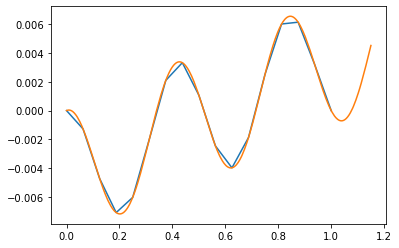

In [580]:
Y = np.linspace(0,1,100)
plt.plot(Xs,S)
plt.plot(X8,s8)